In [2]:
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")

import sys
import numpy as np
import mmwave.dsp as dsp
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from scipy import signal
from mmwave.dsp.utils import Window
import math
from operator import add
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from FER.utils import parseConfigFile, arange_tx
from mmwave.dsp.cfar import ca

# plotting color
import matplotlib._color_data as mcd

# configure file path
# configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_30s.cfg'
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_30s_20fps.cfg'

In [3]:
def butter_bandpass_fs(sig, lowcut, highcut, fs):
    sos = signal.butter(4, [lowcut, highcut], 'bandpass', fs=fs, analog=False, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

In [3]:
# file path
# adc_data_path = "D:/Subjects/Distance_100cm/Neutral_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Heartbeat/Heartbeat_0_Raw_0.bin"
# adc_data_path_1 = "C:/Users/Zber/Desktop/Subjects/Heartbeat/Heartbeat_0_Raw_1.bin"
adc_data_path = "C:/Users/Zber/Desktop/Subjects/Heartbeat/Heartbeat_2_Raw_0.bin"

In [5]:
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'
adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Surprise_100cm_fan_movePeople_9_Raw_0.bin"

In [6]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
configParameters = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = configParameters['numFrames']
numADCSamples = configParameters['numAdcSamples']
numLoopsPerFrame = configParameters['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(numADCSamples,
                                                    dig_out_sample_rate=configParameters['digOutSampleRate'],
                                                    freq_slope_const=configParameters['freqSlopeConst'])
doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=configParameters['startFreq'],
                                            ramp_end_time=configParameters['rampEndTime'],
                                            idle_time_const=configParameters['idleTime'],
                                            num_loops_per_frame=configParameters['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))

Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [5]:
# load file and range processing
# (1) Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data_1 = np.fromfile(adc_data_path_1, dtype=np.int16)

adc_data= np.concatenate([adc_data, adc_data_1])

adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# range processing
range_data = dsp.range_processing(adc_data)
# range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

NameError: name 'adc_data_path_1' is not defined

In [6]:
# load file and range processing
# (1) Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# range processing
range_data = dsp.range_processing(adc_data)
# range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


(400, 32, 12, 256)


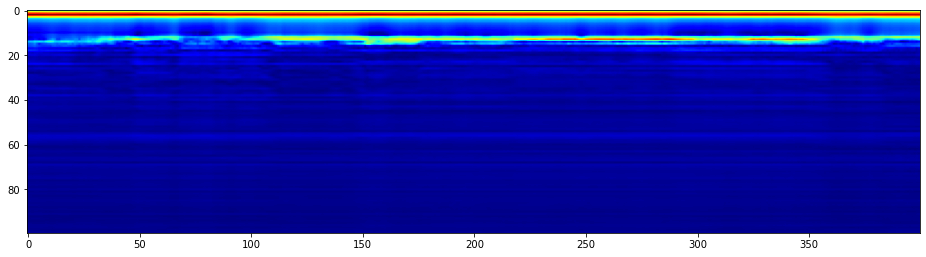

In [7]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
# range_plot_data = np.mean(range_data[:,:,:,:100],axis=(1,2))
range_plot_data = np.mean(range_data[:,:,3,:100],axis=(1))
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]
axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'))

In [9]:
remove_clutter = True
if remove_clutter:
    mean = range_data.mean(2, keepdims=True)
    range_data = range_data - mean

(400, 32, 12, 256)


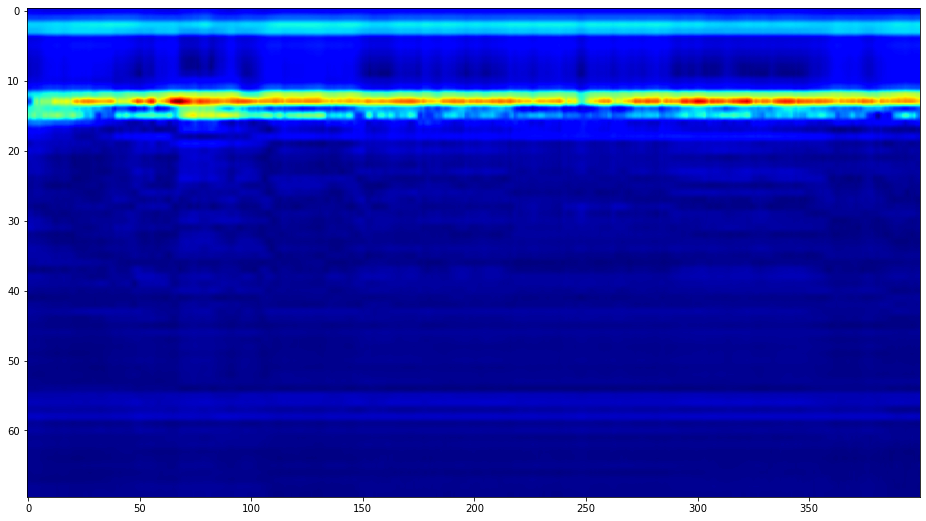

In [8]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
range_plot_data = np.mean(range_data[:,:,:,:70],axis=(1,2))
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]
axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'), aspect='auto')

16
13


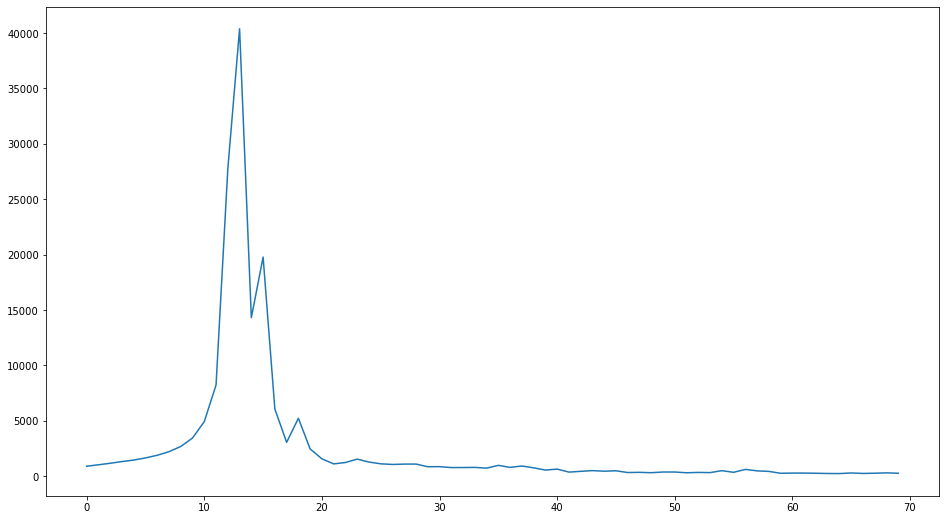

In [9]:
fig6, axes6 = plt.subplots(1, 1, figsize=(16, 9))
range_plot_data = np.mean(range_data[:,:,:,:70],axis=(1,2))

amp_phase =  np.std(range_plot_data, axis=0)

variance_phase = np.std(np.angle(range_plot_data), axis=0)
axes6.plot(amp_phase)

max_index = np.argmax(variance_phase[10:20]) + 10
print(max_index)

max_amp_index = np.argmax(amp_phase)
print(max_amp_index)

[12 13 14 15 30 31]


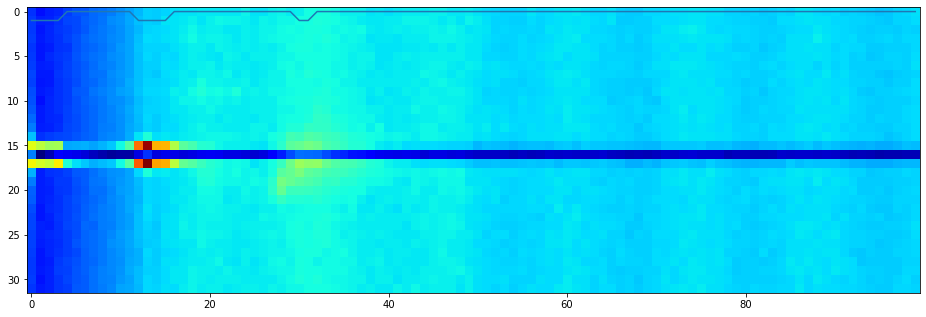

In [10]:

# %matplotlib widget
s_bin = 0
e_bin = s_bin + 100
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                    clutter_removal_enabled=True,
                                                    window_type_2d=Window.HAMMING,
                                                    accumulate=True)

# det_matrix, aoa_input = doppler_processing(range_data, num_tx_antennas=numTxAntennas,
#                                                     clutter_removal_enabled=True,
#                                                     window_type_2d=Window.HAMMING,
#                                                     accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = np.mean(det_matrix_vis[50:100, :, :], axis=0)
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=8)[s_bin:e_bin]

axes.plot(peak_data)
# axes.axvline(x=20, color='r', linestyle='-')
# axes.axvline(x=24, color='r', linestyle='-')

axes.imshow(np.abs(det_matrix_vis_mean.T[:,s_bin:e_bin]), cmap=plt.get_cmap('jet'))
det_matrix_vis.shape
offset = 5
peak_data = peak_data[offset:offset+200]
detect_pos = np.where(peak_data == True)[0]
detect_pos += offset
print(detect_pos)

In [11]:
range_data.shape

(400, 32, 12, 256)

In [17]:
bin_index = 13
chirp_index=5
v_antenna_index=3
# phase_data = np.mean(np.angle(range_data[:, chirp_index:, v_antenna_index, bin_index]), axis=(1))
phase_data = np.angle(range_data[:, chirp_index, v_antenna_index, bin_index])
# unwrap_phase = np.unwrap(2*phase_data, discont=0.1)/2
unwrap_phase = np.unwrap(phase_data, axis=0)
# unwrap_phase = np.mean(unwrap_phase, axis=(1,2))
# unwrap_phase = unwrap_phase[::5]
diff_phase = np.diff(unwrap_phase)
fft_phase = np.fft.fft(diff_phase)

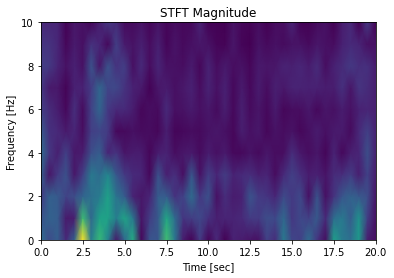

In [19]:
from scipy.signal import stft
f, t, Zxx = signal.stft(diff_phase, fs=20, nperseg=20)
plt.pcolormesh(t, f, np.abs(Zxx),  shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


c:\Users\Zber\anaconda3\envs\Emo\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


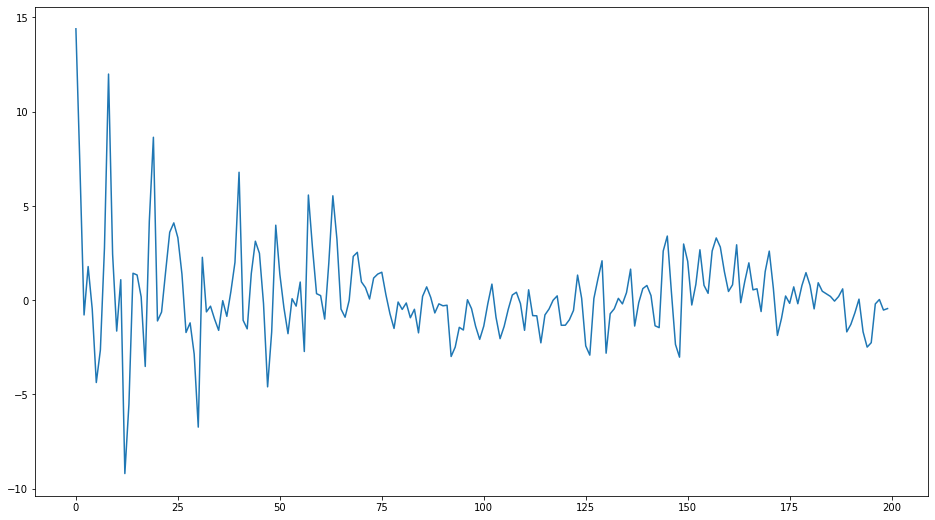

In [21]:
fig00, ax00 = plt.subplots(1, 1, figsize=(16, 9))
ax00.plot(fft_phase[:200])

In [45]:
bin_index = 16
chirp_index=5
v_antenna_index=8
phase_data = np.mean(np.angle(range_data[:, :, 9, bin_index]), axis=(1))
# unwrap_phase = np.unwrap(2*phase_data, discont=0.1)/2
unwrap_phase = np.unwrap(phase_data, axis=0)
# unwrap_phase = np.mean(unwrap_phase, axis=(1,2))
# unwrap_phase = unwrap_phase[::5]
diff_phase = np.diff(unwrap_phase, n=3)

In [ ]:
from scipy.signal import stft
fft_phase = np.fft.fft(phase_data)

f, t, Zxx = signal.stft(phase_data, fs=40, nperseg=20)
plt.pcolormesh(t, f, np.abs(Zxx),  shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

c:\Users\Zber\anaconda3\envs\Emo\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


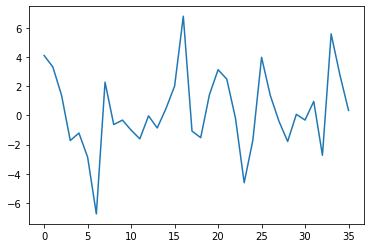

In [22]:
plt.plot(fft_phase[24:60])
plt.show()

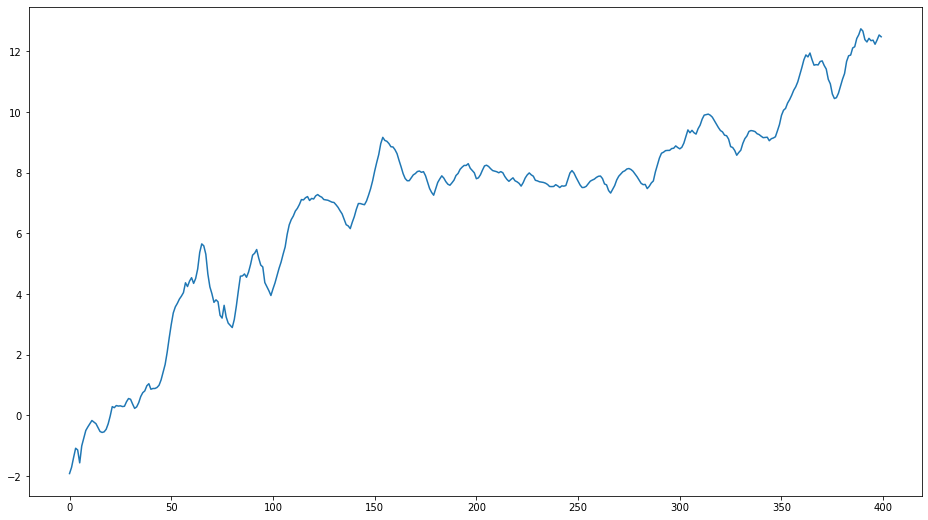

In [23]:
fig1, ax0 = plt.subplots(1, 1, figsize=(16, 9))
ax0.plot(unwrap_phase)

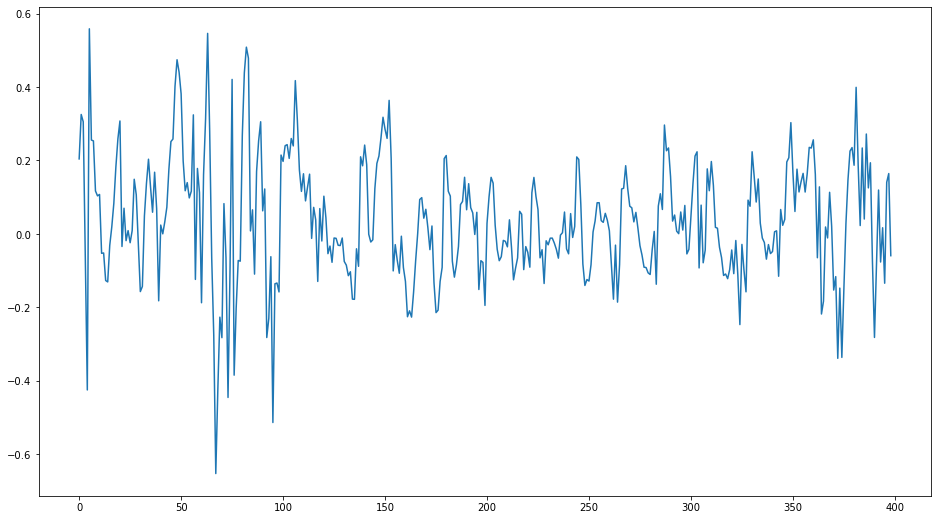

In [24]:
fig1, ax1 = plt.subplots(1, 1, figsize=(16, 9))
ax1.plot(diff_phase)

In [ ]:
masks = np.abs(diff_phase) > 1 
p_masks = np.concatenate([np.asarray([False]),masks[:-1]])
af_masks = np.concatenate([masks[1:], np.asarray([False])])
diff_phase[masks] = diff_phase[masks]-diff_phase[p_masks]-diff_phase[af_masks]

In [257]:
new_masks = np.abs(diff_phase) > 0.5
diff_phase[new_masks] = np.mean(diff_phase) 


In [22]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [23]:
hb_signal = butter_bandpass_filter(diff_phase, lowcut=0.8, highcut=2.0, fs=20, order=8)
breath_signal = butter_bandpass_filter(diff_phase, lowcut=0.1, highcut=0.5, fs=20, order = 5)

In [29]:
hb_l, hb_h = 0.8, 2.0
b_l, b_h = 0.05, 0.5

In [30]:
hb_signal = butter_bandpass_fs(diff_phase, lowcut=hb_l, highcut=hb_h, fs=20)
breath_signal = butter_bandpass_fs(diff_phase, lowcut=b_l, highcut=b_h, fs=20)

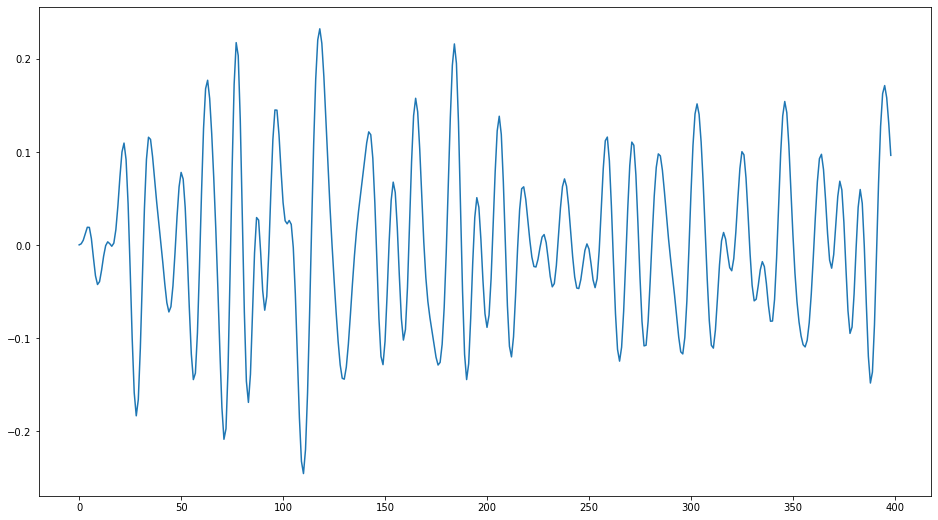

In [31]:
fig2, ax2 = plt.subplots(1, 1, figsize=(16, 9))
ax2.plot(hb_signal)

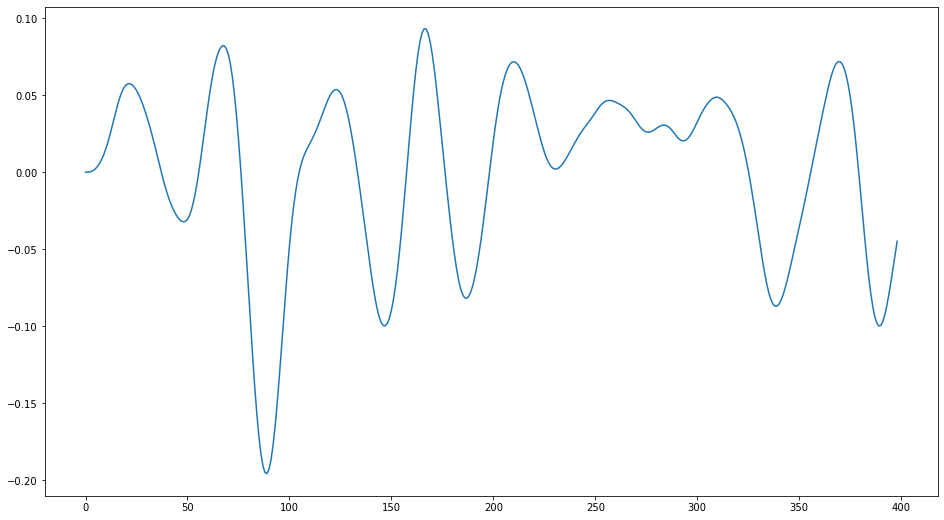

In [32]:
fig5, ax5 = plt.subplots(1, 1, figsize=(16, 9))
ax5.plot(breath_signal)